# Importing Packages Needed

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as py
from scipy.optimize import curve_fit
#from scipy.signal import find_peaks
import collections as col
from scipy.interpolate import UnivariateSpline

# Definition of Named Tuples

In [2]:
component = col.namedtuple('component','phase intensity')
ind_sub = col.namedtuple('ind_sub','phase intensity width')
pulse_sub = col.namedtuple('pulse_sub','frequency sub1 sub2, errors')
pulse_fits = col.namedtuple('pulse_fits','thorsett, powerlaw, linear')
one_fit = col.namedtuple('one_fit','params, errors, cov, chir')
pl_av = col.namedtuple('pl_av', 'frequency, phase')

# Definition of Functions

Functions needed to calculate chi squared values and find error in pulse data

In [3]:
def chsq(observed_values, expected_values, err):
    """
    Chi Squared operation:
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [4]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Sigma clipping operation:
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

Gaussian Fitting Functions:

In [5]:
"""
Definitions of gaussian equations - single, double and triple
"""

def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def twogauss(x,amp1,cen1,sd1,amp2,cen2,sd2):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)

def threegauss(x,amp1,cen1,sd1,amp2,cen2,sd2,amp3,cen3,sd3):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)+gauss(x,amp3,cen3,sd3)

In [6]:
"""
Fitting data into the above gaussian equations. 

Parameters:
    -----------
    x,y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
    expect: list
        The expected parameters for the gaussian equation

    Returns:
    --------
    params: list
        The parameters (x, cen, sd) of the fit
    cov: list
        The covariance of the fit
    fit: list
        The y data of the actual fit (parameters have been put back into the equation)
    chi: float
        The chi squared value
"""

def single_fit(x, y, error, expect):
    params,cov=curve_fit(gauss,x,y,expect,bounds=([-np.inf,-np.inf,0],[np.inf,np.inf,np.inf]))
    fit=gauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-3)
        
    return params, cov, fit, chir

def double_fit(x, y, error, expect):
    params,cov=curve_fit(twogauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=twogauss(x,*params)

    chi=chsq(y, fit, error)
    chir=chi/(len(y)-6)
    
    return params, cov, fit, chir

def triple_fit(x, y, error, expect):
    params,cov=curve_fit(threegauss,x,y,expect,bounds=([-np.inf,-np.inf,0,-np.inf,-np.inf,0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    fit=threegauss(x,*params)
    
    chi=chsq(y, fit, error)
    chir=chi/(len(y)-9)
    
    return params, cov, fit, chir

In [7]:
"""
    Fitting Gaussians operation:
    Creates a double gaussian fit for the data.
    First attempts a fit with expected left subpulse, and if this fails it then attempts a fit with the right. 
    If these fail create a no fit.
    
    Then checks if a double fit is created, the chi value and if over 1100, replaces it with a single fit instead. 
    If chi of a single fit is still above 1100 then replaces it with a no fit. 

    Parameters:
    -----------
    x, y: list, list
        A list of floats - the data 
    error: float
        The error across all data - standard deviation of the noise
        
    Returns:
    --------
    fit: list
        The y data of the best fit 
    params: list
        The parameters (x, cen, sd) of the best fit
    sigma: list
        List of the errors in the parameters
    chi: float
        The chi squared reduced value
""" 

def fitting_gaussians(x,y, error):   
    mx=max(y)
    yl=list(y)
    mx_ind=yl.index(mx)
    mx_ph=x[mx_ind]
    
    #Attempts to use the peak of the data as an expected value, if it is in the correct range
    if mx_ph>300 and mx_ph<550:
        expect1=[mx,mx_ph,20,20,700,100]
    else:
        expect1=[70,400,20,20,700,100]
    if mx_ph>550 and mx_ph<700:
        expect2=[20,400,100,mx,mx_ph,20]
    else:
        expect2=[20,400,100,70,700,20]
    
    #Attempts to first create a fit using expected left peak
    try:
        params1, cov1, fit1, chir1 = double_fit(x, y, error, expect1)
        sigma1=np.sqrt(np.diag(cov1))
    except Exception as e:
        params1=0
        fit1=[]
        chir1=5000
        sigma1=0
        cov1=0
    #Then attempts to create a fit using expected right peak
    try:
        params2, cov2, fit2, chir2 = double_fit(x, y, error, expect2)
        sigma2=np.sqrt(np.diag(cov2))
    except Exception as r:
        params2=0
        fit2=[]
        chir2=5000
        sigma2=0
        cov2=0
    
    #Then use the fit with the best chi squared reduced value
    if abs(chir1-1)<=abs(chir2-1) and abs(chir1-1)<2:
        params=params1
        fit=fit1
        chir=chir1
        sigma=sigma1
        cov=cov1
    elif abs(chir2-1)<=abs(chir1-1) and abs(chir2-1)<2:
        params=params2
        fit=fit2
        chir=chir2
        sigma=sigma2 
        cov=cov2
    else:
        params=0
        fit=[]
        chir=np.inf
        sigma=0
        cov=0
        
    return fit, params, sigma, cov, chir

Finding Peak of Gaussian Fittings Function

In [8]:
def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [9]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err

In [10]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [11]:
def gauss_peaksn(fit, nofreqband, freqband, cov, params,freq_low,freq_high):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    minima, peakpos, minima_e, err=find_minima_maxima_gauss(params, cov, len(fit))
    peakint = twogauss(peakpos, *params)
    
    #Delete the peak with the least intensity until there is only one peak left
    while len(peakpos)>1:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        del peakpos[rm]
        del peakint[rm]
        del err[rm]
    
    #Assign the peaks to be either subpulse 1 or 2, also converts phase from bins to degrees
    if len(peakpos)==1 and peakpos[0]<470 and peakpos[0]>200 and peakint[0]>20:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=0, intensity=0)
        error = np.array(err)*(deg_mod)
    elif len(peakpos)==1 and peakpos[0]>570 and peakpos[0]<800 and peakint[0]>20:
        component2 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component1 = component(phase=0, intensity=0)
        error = np.array(err)*(deg_mod)        
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0

    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low
    profile_comp = pulse_sub(frequency=freq, sub1=component1, sub2=component2, errors=error)

    return profile_comp

Plotting Fittings Functions

In [12]:
"""
    Plotting operations:
    Used to make different plots of the fits, their components and peaks.
"""
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [13]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
  
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)

    return 

In [14]:
def plot_peaks(x,y,profile_comp):
    py.plot((360/1024)*x,y, lw=0.5)
    py.plot((360/1024)*x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Component Movement Data

In [15]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))
def linear(x, m, c):
    return (x * m+c)

In [16]:
def jacobian_slope_pl(length,x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def ddA(A, alpha, x):
        return (1/length)*x**alpha
    def ddalpha(A, alpha, x):
        return (1/length)*alpha*A*x**(alpha-1)
    J = []
    for i in range(0, len(params), 2):
        A = params[i]
        alpha = params[i+1]
        mypars = [A, alpha, x]
        J.append(ddA(*mypars))
        J.append(ddalpha(*mypars))
    J = np.asmatrix(J)
    return J

In [17]:
def find_y_err_pl(x, popt, pcov):
    #x=list of all frequencys. popt = parameter list across all pulses. pcov=covarience matrix for all pulses
    #Combine multiple cov matrices into one
    cov=np.zeros((len(pcov)*2,len(pcov)*2))
    for i, c in enumerate(pcov):
        cov[i*2][i*2]=c[0][0]
        cov[i*2][i*2+1]=c[0][1]
        cov[i*2+1][i*2]=c[1][0]
        cov[i*2+1][i*2+1]=c[1][1]
    err=[]
    for i, point in enumerate(x):
        J = jacobian_slope_pl(len(x),point, *popt)
        JC = np.matmul(J, cov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        err.append(sigma_y)
    return err
#returns a list of errors

Extra Stuff

In [18]:
"""
    Graphing Sub-pulse operation:
    Used to get the correct x, y and error arrays created for graphing the data and finding a fit.
"""
def graphing_spulse(fit_spulse,spulse_num):
        phase_comp=[]
        frequency_comp=[]
        comp_err=[]

        if spulse_num==1:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][1][0] != 0:# and fit_spulse[i][3][0]<4:
                    phase_comp.append(fit_spulse[i][1][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][0])
        elif spulse_num==2:
            for i in range(0,len(fit_spulse)):
                if fit_spulse[i][2][0] != 0:# and fit_spulse[i][3][3]<4:
                    phase_comp.append(fit_spulse[i][2][0])
                    frequency_comp.append(fit_spulse[i][0])
                    comp_err.append(fit_spulse[i][3][0])
        
        return phase_comp, frequency_comp, comp_err    

In [19]:
"""
    Removing outliers operation
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err):
    phase=[]
    frequency=[]
    err=[]
    
    threshold=1.5
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        z_score= (phase_comp[i] - mean_1)/std_1 
        if np.abs(z_score) < threshold:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

In [20]:
"""
    Three fits operation
    Attempts to fit a thorsett, power law and linear equation to the data. Also calculates chi squared and reduced 
"""

def three_fits(frequency_comp, phase_comp, comp_err): 
    
    try:
        expect=[100,0.1,0.1]
        thorsett_params,thorsett_cov=curve_fit(thorsett,frequency_comp,phase_comp, expect, maxfev=100000, sigma=comp_err)
        thorsett_fit_error=np.sqrt(np.diag(thorsett_cov))
        thorsettf = thorsett(frequency_comp, *thorsett_params)

        ch=chsq_err(phase_comp,thorsettf, comp_err)
        chre=ch/(len(phase_comp)-3)

        thorsett_fit=one_fit(params=thorsett_params, errors=thorsett_fit_error, cov=thorsett_cov, chir=chre)  
    except:
        print('No thorsett for component')
        thorsett_fit=0

    try:
        expect=[100,0.1]
        pl_params,pl_cov=curve_fit(powerlaw,frequency_comp,phase_comp, expect, maxfev=100000, sigma=comp_err)
        pl_fit_error=np.sqrt(np.diag(pl_cov))
        powerlawf = powerlaw(frequency_comp, *pl_params)

        ch=chsq_err(phase_comp,powerlawf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        pl_fit=one_fit(params=pl_params, errors=pl_fit_error, cov=pl_cov, chir=chre)
    except:
        print('No power law for component')
        pl_fit=0

    try:
        lin_params,lin_cov=curve_fit(linear,frequency_comp,phase_comp)
        lin_fit_error=np.sqrt(np.diag(lin_cov))
        linearf = linear(np.array(frequency_comp), *lin_params)
       
        ch=chsq_err(phase_comp,linearf, comp_err)
        chre=ch/(len(phase_comp)-2)
        
        lin_fit=one_fit(params=lin_params, errors=lin_fit_error, cov=lin_cov, chir=chre)
    except:
        print('No linear for component')
        lin_fit=0
        
    pulse_fit=pulse_fits(thorsett=thorsett_fit, powerlaw=pl_fit, linear=lin_fit)
    
    return pulse_fit

# INDIVIDUAL FREQUENCY BAND

## Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

In [21]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [22]:
single_pulse = np.loadtxt(fname='/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256_new/pulse_1503960513.f256_pazi.pdv', dtype=fulldatatype)

In [23]:
no_freq_bands = max(single_pulse['frequency'])+1

## Gaussian Fitting - Broken Down for Each Frequency

Following Section is for error checking:

From all the frequency profiles it takes only the one frequency band. 

In [24]:
#Isolating a single frequency for a pulse
freqband = 5
f = single_pulse['frequency'] == freqband

phase=single_pulse['phase'][f]
intensity=single_pulse['intensity'][f]
x = phase
y = intensity

In [25]:
len(y)

1024

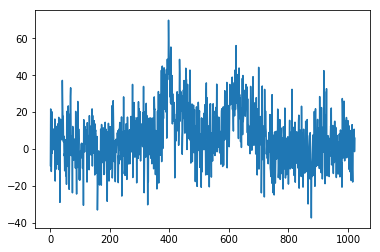

In [26]:
py.plot(x,y)

Calculates the noise of the data. The standard deviation of this is then the error in the data. 

In [27]:
noise = sigmaClip(y)
error = np.nanstd(noise[1])
print(error)

14.899773325708042


In [28]:
#Attempts to fit two gaussians to the data
#Uses two expected values and returns the fit with the best chi squared reduced values
fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)

pulse_sub(frequency=433.33333333333337, sub1=component(phase=144.53444988134603, intensity=28.095299069572754), sub2=component(phase=0, intensity=0), errors=array([1.17297241]))


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


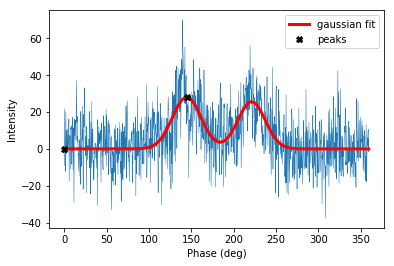

In [29]:
#If there is a fit, finds peaks where derivative is equal to zero, and then takes the highest peak
#Also classifys it as subpulse 1 or 2 depending on location
if fit!=[]:
    pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500)
    plot_peaks(x,y, pulse_subp)
    print(pulse_subp)

# INDIVIDUAL PULSE

## Gaussian Fitting 

The following is a looped version of the previous section to find the correct peaks for each frequency profile

In [30]:
fit_spulse = []

In [31]:
for i in range(no_freq_bands):
    
    freqband = i
  
    f = single_pulse['frequency'] == freqband

    x=single_pulse['phase'][f]
    y=single_pulse['intensity'][f]
    
    noise = sigmaClip(y)
    error = np.nanstd(noise[1])
    
    if len(y)!=0:
        fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)
        
    if fit!=[] and len(y)!=0:
        pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500) 
        fit_spulse.append(pulse_subp)
    

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


## Change of Peak Position over Frequency

Starting to graph out all the movement of sub-pulse phase across frequency

---



In [32]:
#Separate the data into the correct arrays for graphing
try:
    phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)
    sp1 = "PENDING"
except:
    print("Bad Data Set Comp1")
    sp1 = "ERROR"

In [33]:
if sp1!="ERROR":
    if len(phase_comp1)<3:
        sp1 = "ERROR"

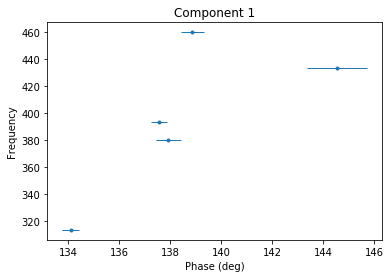

In [34]:
if sp1!="ERROR":
    py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=1, label='data')
    py.title('Component 1')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')

In [35]:
#Remove outliers
if sp1!="ERROR":
    frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err)
if sp1!="ERROR":
    if len(phase_comp1)<3:
        sp1 = "ERROR"

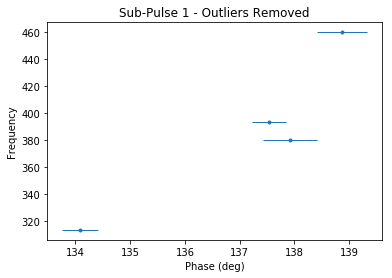

In [36]:
if sp1!="ERROR":
    py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=1, label='data')
    py.title('Sub-Pulse 1 - Outliers Removed')
    py.xlabel('Phase (deg)')
    py.ylabel('Frequency')

In [37]:
try:
    phase_comp2, frequency_comp2, comp2_err=graphing_spulse(fit_spulse,2)
    sp2 = "PENDING"
except:
    print("Bad Data Set Comp2")
    sp2 = "ERROR"

In [38]:
if sp2!="ERROR":
    if len(phase_comp2)<3:
        sp2 = "ERROR"

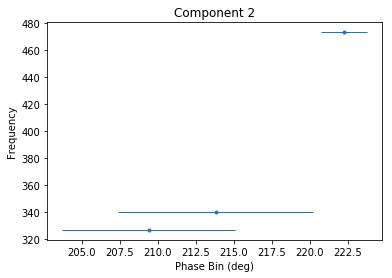

In [39]:
if sp2!="ERROR":
    py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=1, label='data')
    py.title('Component 2')
    py.xlabel('Phase Bin (deg)')
    py.ylabel('Frequency')

In [40]:
if sp2!="ERROR":
    frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err)
if sp2!="ERROR":
    if len(phase_comp2)<3:
        sp2 = "ERROR"

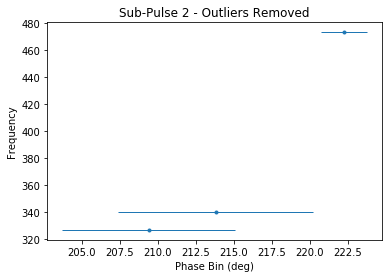

In [41]:
if sp2!="ERROR":
    py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=1, label='data')
    py.title('Sub-Pulse 2 - Outliers Removed')
    py.xlabel('Phase Bin (deg)')
    py.ylabel('Frequency')

## Fitting Power Laws to Position

### Component 1

The thorsett equation of fit for this pulse is: 	 Phase = 15766.616 ν^0.001 + -15708.431
The errors are 30743282.91180348, 1.6273122421594721, 30743666.177613206
The chi squared reduced is -1.321035459198004, and the chi squared is 6.715858163207984

The power law equation of fit for this pulse is: 	 Phase = 76.962 ν^0.097
The errors are 8.627288808218161, 0.018913902154136474
The chi squared reduced is -0.2551782093878092, and the chi squared is 6.979287162448763

The linear equation of fit for this pulse is: 		 Phase = 0.032 ν + 124.708 
The errors are 0.009330933623832452, 3.6405260385027605
The chi squared reduced is 0.6533555887811975, and the chi squared is 10.61342235512479


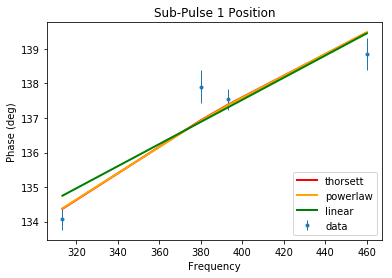

In [42]:
#Same as the three fits function but with graphing included
if sp1!="ERROR":
    py.errorbar(frequency_comp1,phase_comp1, yerr=comp1_err, fmt='.', lw=1, label='data')

    try:
        thorsett_params1,thorsett_cov1=curve_fit(thorsett,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
        thorsett_fit_error1=np.sqrt(np.diag(thorsett_cov1))
        thorsett1 = thorsett(frequency_comp1, *thorsett_params1)
        
        py.plot(frequency_comp1,thorsett1, color='red',lw=2,label='thorsett')
        
        ch=chsq_err(phase_comp1,thorsett1, comp1_err)
        chre=ch/len(phase_comp1)-3
        print(f'The thorsett equation of fit for this pulse is: \t Phase = {thorsett_params1[0]:.3f} \u03BD^{thorsett_params1[1]:.3f} + {thorsett_params1[2]:.3f}')
        print(f'The errors are {thorsett_fit_error1[0]}, {thorsett_fit_error1[1]}, {thorsett_fit_error1[2]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    except:
        print('No thorsett for component 1')

    try:
        pl_params1,pl_cov1=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=100000, sigma=comp1_err)
        pl_fit_error1=np.sqrt(np.diag(pl_cov1))
        powerlaw1 = powerlaw(frequency_comp1, *pl_params1)

        py.plot(frequency_comp1,powerlaw1, color='orange',lw=2,label='powerlaw')
        
        ch=chsq_err(phase_comp1,powerlaw1, comp1_err)
        chre=ch/len(phase_comp1)-2
        print(f'The power law equation of fit for this pulse is: \t Phase = {pl_params1[0]:.3f} \u03BD^{pl_params1[1]:.3f}')
        print(f'The errors are {pl_fit_error1[0]}, {pl_fit_error1[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    except:
        print('No power law for component 1')

    try:
        lin_params1,lin_cov1=curve_fit(linear,frequency_comp1,phase_comp1)
        lin_fit_error1=np.sqrt(np.diag(lin_cov1))
        linear1 = linear(np.array(frequency_comp1), *lin_params1)
        
        py.plot(frequency_comp1,linear1, color='green',lw=2,label='linear')
        
        
        ch=chsq_err(phase_comp1,linear1, comp1_err)
        chre=ch/len(phase_comp1)-2
        print(f'The linear equation of fit for this pulse is: \t\t Phase = {lin_params1[0]:.3f} \u03BD + {lin_params1[1]:.3f} ')
        print(f'The errors are {lin_fit_error1[0]}, {lin_fit_error1[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}')
    except:
        print('No linear for component 1')    


    py.title('Sub-Pulse 1 Position')
    py.xlabel('Frequency')
    py.ylabel('Phase (deg)')
    py.legend(loc='lower right')
    

In [43]:
if sp1!="ERROR":
    comp1_fit=three_fits(frequency_comp1, phase_comp1, comp1_err)

### Component 2

The thorsett equation of fit for this pulse is: 	 Phase = 17106.655 ν^0.002 + -17074.743
The errors are inf, inf, inf
The chi squared reduced is -2.954848010061861, and the chi squared is 0.13545596981441765

The power law equation of fit for this pulse is: 	 Phase = 91.940 ν^0.143
The errors are 12.552971160077398, 0.022291997334555908
The chi squared reduced is -1.9539766971056596, and the chi squared is 0.138069908683021

The linear equation of fit for this pulse is: 		 Phase = 0.078 ν + 185.682 
The errors are 0.020731365894284776, 7.996644105693662
The chi squared reduced is -1.944852753635342, and the chi squared is 0.16544173909397422


/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


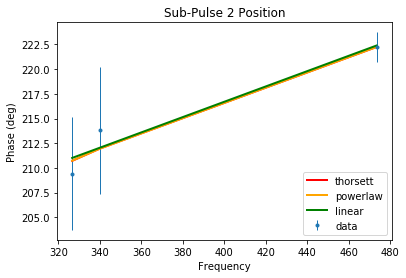

In [44]:
if sp2!="ERROR":
    py.errorbar(frequency_comp2,phase_comp2, yerr=comp2_err, fmt='.', lw=1, label='data')

    #try:
    thorsett_params2,thorsett_cov2=curve_fit(thorsett,frequency_comp2,phase_comp2, maxfev=100000, sigma=comp2_err)
    thorsett_fit_error2=np.sqrt(np.diag(thorsett_cov2))
    thorsett2 = thorsett(frequency_comp2, *thorsett_params2)
        
    py.plot(frequency_comp2,thorsett2, color='red',lw=2,label='thorsett')
        
    ch=chsq_err(phase_comp2,thorsett2, comp2_err)
    chre=ch/len(phase_comp2)-3
    print(f'The thorsett equation of fit for this pulse is: \t Phase = {thorsett_params2[0]:.3f} \u03BD^{thorsett_params2[1]:.3f} + {thorsett_params2[2]:.3f}')
    print(f'The errors are {thorsett_fit_error2[0]}, {thorsett_fit_error2[1]}, {thorsett_fit_error2[2]}')
    print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    #except:
        #print('No thorsett for component 2')

    try:
        pl_params2,pl_cov2=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=100000, sigma=comp2_err)
        pl_fit_error2=np.sqrt(np.diag(pl_cov2))
        powerlaw2 = powerlaw(frequency_comp2, *pl_params2)

        py.plot(frequency_comp2,powerlaw2, color='orange',lw=2,label='powerlaw')
        
        ch=chsq_err(phase_comp2,powerlaw2, comp2_err)
        chre=ch/len(phase_comp2)-2
        print(f'The power law equation of fit for this pulse is: \t Phase = {pl_params2[0]:.3f} \u03BD^{pl_params2[1]:.3f}')
        print(f'The errors are {pl_fit_error2[0]}, {pl_fit_error2[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}\n')
    except:
        print('No power law for component 2')

    try:
        lin_params2,lin_cov2=curve_fit(linear,frequency_comp2,phase_comp2)
        lin_fit_error2=np.sqrt(np.diag(lin_cov2))
        linear2 = linear(np.array(frequency_comp2), *lin_params2)
        
        py.plot(frequency_comp2,linear2, color='green',lw=2,label='linear')
        
        
        ch=chsq_err(phase_comp2,linear2, comp2_err)
        chre=ch/len(phase_comp2)-2
        print(f'The linear equation of fit for this pulse is: \t\t Phase = {lin_params2[0]:.3f} \u03BD + {lin_params2[1]:.3f} ')
        print(f'The errors are {lin_fit_error2[0]}, {lin_fit_error2[1]}')
        print(f'The chi squared reduced is {chre}, and the chi squared is {ch}')
    except:
        print('No linear for component 2')    


    py.title('Sub-Pulse 2 Position')
    py.xlabel('Frequency')
    py.ylabel('Phase (deg)')
    py.legend(loc='lower right')
    

In [45]:
if sp2!="ERROR":
    comp2_fit=three_fits(frequency_comp2, phase_comp2, comp2_err)

No thorsett for component


/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# ALL PULSES

In [46]:
def find_fits(fit_spulse):
    sp1 = "PENDING"
    sp2 = "PENDING"
    
    #Find the movement of pulse across frequency for comp1
    try:
        phase_comp1, frequency_comp1, comp1_err=graphing_spulse(fit_spulse,1)
    except:
        print("Bad Data Set Comp1")
        sp1 = "ERROR"
        phase_comp1=[0]

    if sp1!="ERROR":
        frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err)
        if len(phase_comp1)<4:
            sp1 = "ERROR"
            phase_comp1=[0]
    
    #Find the movement of pulse across frequency for comp2
    try:
        phase_comp2, frequency_comp2, comp2_err=graphing_spulse(fit_spulse,2)
    except:
        print("Bad Data Set Comp2")
        sp2 = "ERROR"
        phase_comp2=[0]

    if sp2!="ERROR":
        frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err)
        if len(phase_comp2)<4:
            sp2 = "ERROR"
            phase_comp2=[0]
    
    #Fit thorsett, powerlaw and linear equations to the data for comp with most points
    if sp1!="ERROR" and len(phase_comp1)>len(phase_comp2):
        comp1_fit=three_fits(frequency_comp1, phase_comp1, comp1_err)
    else:
        comp1_fit=0
        
    if sp2!="ERROR" and len(phase_comp2)>len(phase_comp1):
        comp2_fit=three_fits(frequency_comp2, phase_comp2, comp2_err)
    else:
        comp2_fit=0


    return comp1_fit, comp2_fit    


In [47]:
import glob 
pulse_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse*")
#pulse_names = glob.glob("/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256_new/pulse*")

In [48]:
print(len(pulse_names))
pulse_names=sorted(pulse_names)
print(pulse_names[0])

9661
/home/lisasmith/sspulsar/archivefiles/s_archivefiles/f256/full_pdv/pulse_1503960507.pazi.pdv


In [49]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [50]:
def average(num_list):
    sum_num=0
    for n in num_list:
        sum_num=sum_num+n
    avg=sum_num/len(num_list)
    return avg

def average_plfits(comp_params):
    param1=[]
    param2=[]
    for i, fit in enumerate(comp_params):
        param1.append(fit[0][0])
        param2.append(fit[0][1])

    av_param1=average(param1)
    av_param2=average(param2)
    return av_param1, av_param2

def create_pl_fit(lower,upper,param1,param2):
    x=list(range(lower,upper))
    y=[]
    for freq in x:
        y.append(param1 * (freq**(param2)))
    return x,y
    

0 1503960507


/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


224.5249630464932
1 1503960508
2 1503960509
3 1503960510
4 1503960511
5 1503960512
6 1503960513
7 1503960514


/usr/lib/python3/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


8 1503960515


/usr/lib/python3/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


9 1503960516
10 1503960517
11 1503960518


/home/lisasmith/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


224.78797815256718
12 1503960519
225.27879296895978
13 1503960520
223.49668334378902
14 1503960521
225.24119819908157
15 1503960522
16 1503960523
224.49808420852753
17 1503960524


/home/lisasmith/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


223.7436203959078
18 1503960525
19 1503960526
20 1503960527
21 1503960528
22 1503960529
23 1503960530
24 1503960531
25 1503960532
26 1503960533
238.0069644004052
27 1503960534
28 1503960535
29 1503960536
30 1503960537
224.01798379666235
31 1503960538
221.00105126616498
32 1503960539
222.6527986977459
33 1503960540
227.24493914314803
34 1503960541
224.66626667648615
35 1503960542
221.82042888163517
36 1503960543
221.64166247467935
37 1503960544
223.97675650068848
38 1503960545
223.1308331364904
39 1503960546
40 1503960547
41 1503960548
42 1503960549
43 1503960550
44 1503960551
45 1503960552


/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


46 1503960553
47 1503960554
48 1503960555
49 1503960556
227.48152706128005
50 1503960557
225.26151489649385
51 1503960558
226.79405697317128
52 1503960559
223.94005506621977
53 1503960560
54 1503960561
55 1503960562
225.43154730105456
56 1503960563
223.11961458518203
57 1503960564
58 1503960565
59 1503960566
60 1503960567
61 1503960568
226.87224486863198
62 1503960569
63 1503960570
64 1503960571
65 1503960572
66 1503960573
67 1503960574
68 1503960575
69 1503960576
70 1503960577
219.15545109841608
71 1503960578
224.4768790629149
72 1503960579
226.575542075461
73 1503960580
226.78513496280448
74 1503960581
228.60134911909202
75 1503960582
227.48342471313987
76 1503960583
77 1503960584
223.9643605744545
78 1503960585
223.4454721142801
79 1503960586
217.81104003564445
80 1503960587
81 1503960588
82 1503960589
83 1503960590
84 1503960591
85 1503960592
86 1503960593
87 1503960594
88 1503960595
89 1503960596
90 1503960597
91 1503960598
229.33162744441833
92 1503960599
224.24759712043303
93 15

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


144 1503960651
145 1503960652
146 1503960653
147 1503960654
148 1503960655
149 1503960656
150 1503960657
151 1503960658
236.87092506345695
152 1503960659
229.08892429217025
153 1503960660
226.05715457302927
154 1503960661
222.42919608845185
155 1503960662
222.65716241624557
156 1503960663
227.10154975325557
157 1503960664
158 1503960665
159 1503960666
218.5715670955835
160 1503960667
161 1503960668
162 1503960669
163 1503960670
164 1503960671
165 1503960672
166 1503960673
167 1503960674
168 1503960675
169 1503960676
170 1503960677
171 1503960678
231.6409204296306
172 1503960679
211.04138837952547
173 1503960680
235.5881870119665
174 1503960681
175 1503960682
176 1503960683
177 1503960684
178 1503960685
179 1503960686
180 1503960687
181 1503960688
182 1503960689
183 1503960690
184 1503960691
185 1503960692
186 1503960693
187 1503960694
188 1503960695
189 1503960696
190 1503960697
191 1503960698
192 1503960699
193 1503960700
194 1503960701
195 1503960702
196 1503960703
197 1503960704
198

610 1503961117
611 1503961118
612 1503961119
613 1503961120
614 1503961121
218.3996730375604
615 1503961122
229.1892697008651
616 1503961123
226.63864386707837
617 1503961124
224.85709603614376
618 1503961125
619 1503961126
620 1503961127
621 1503961128
223.37519436832048
622 1503961129
623 1503961130
624 1503961131
625 1503961132
626 1503961133
627 1503961134
628 1503961135
629 1503961136
630 1503961137
221.19854597403375
631 1503961138
219.07744639872027
632 1503961139
633 1503961140
634 1503961141
228.55548051481975
635 1503961142
222.96501350183271
636 1503961143
637 1503961144
229.72073676331178
638 1503961145
222.27264795986406
639 1503961146
640 1503961147
641 1503961148
642 1503961149
643 1503961150
644 1503961151
645 1503961152
646 1503961153
647 1503961154
648 1503961155
649 1503961156
650 1503961157
221.60254404160384
651 1503961158
231.3441026374077
652 1503961159
233.79865736073276
653 1503961160
231.30651331978544
654 1503961161
225.43584247453919
655 1503961162
221.10599

/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


945 1503961452
946 1503961453
947 1503961454
948 1503961455
949 1503961456
950 1503961457
951 1503961458
952 1503961459
953 1503961460
954 1503961461
955 1503961462
956 1503961463
957 1503961464
958 1503961465
959 1503961466
960 1503961467
961 1503961468
962 1503961469
963 1503961470
964 1503961471
965 1503961472
966 1503961473
967 1503961474
968 1503961475
969 1503961476
970 1503961477
971 1503961478
972 1503961479
973 1503961480
974 1503961481
215.1809755472385
975 1503961482
976 1503961483
977 1503961484
978 1503961485
979 1503961486
980 1503961487
981 1503961488
982 1503961489
224.91105604608939
983 1503961490
984 1503961491
985 1503961492
986 1503961493
987 1503961494
988 1503961495
989 1503961496
990 1503961497
991 1503961498
992 1503961499
993 1503961500
994 1503961501
995 1503961502
222.59643285529395
996 1503961503
997 1503961504
998 1503961505
999 1503961506
1000 1503961507
1001 1503961508
1002 1503961509
1003 1503961510
1004 1503961511
1005 1503961512
1006 1503961513
1007 15

1399 1503961906
211.98080023945116
1400 1503961907
222.90184777608314
1401 1503961908
227.09912434799156
1402 1503961909
1403 1503961910
225.09836626049926
1404 1503961911
224.03708942872976
1405 1503961912
225.3299421614695
1406 1503961913
1407 1503961914
1408 1503961915
1409 1503961916
1410 1503961917
1411 1503961918
1412 1503961919
1413 1503961920
1414 1503961921
1415 1503961922
238.14141747860933
1416 1503961923
232.86621861233476
1417 1503961924
222.42581290687536
1418 1503961925
226.15477849311384
1419 1503961926
223.09388713358683
1420 1503961927
1421 1503961928
1422 1503961929
222.70384938335775
1423 1503961930
1424 1503961931
1425 1503961932
1426 1503961933
1427 1503961934
1428 1503961935
1429 1503961936
1430 1503961937
1431 1503961938
1432 1503961939
1433 1503961940
1434 1503961941
1435 1503961942
1436 1503961943
1437 1503961944
1438 1503961945
1439 1503961946
1440 1503961947
1441 1503961948
225.50592463408913
1442 1503961949
1443 1503961950
1444 1503961951
1445 1503961952
14

1879 1503962386
1880 1503962387
1881 1503962388
1882 1503962389
1883 1503962390
1884 1503962391
1885 1503962392
1886 1503962393
1887 1503962394
1888 1503962395
1889 1503962396
1890 1503962397
1891 1503962398
1892 1503962399
1893 1503962400
1894 1503962401
1895 1503962402
1896 1503962403
1897 1503962404
1898 1503962405
1899 1503962406
1900 1503962407
1901 1503962408
1902 1503962409
1903 1503962410
1904 1503962411
1905 1503962412
1906 1503962413
1907 1503962414
1908 1503962415
1909 1503962416
1910 1503962417
1911 1503962418
1912 1503962419
1913 1503962420
1914 1503962421
1915 1503962422
1916 1503962423
226.59211839833645
1917 1503962424
1918 1503962425
1919 1503962426
1920 1503962427
1921 1503962428
1922 1503962429
1923 1503962430
227.92638719896544
1924 1503962431
1925 1503962432
1926 1503962433
224.85240445192562
1927 1503962434
1928 1503962435
1929 1503962436
1930 1503962437
1931 1503962438
1932 1503962439
1933 1503962440
1934 1503962441
1935 1503962442
1936 1503962443
1937 1503962444

230.92480761094006
2374 1503962881
227.85305217091232
2375 1503962882
2376 1503962883
2377 1503962884
2378 1503962885
2379 1503962886
2380 1503962887
2381 1503962888
2382 1503962889
2383 1503962890
245.95568083742162
2384 1503962891
2385 1503962892
2386 1503962893
2387 1503962894
2388 1503962895
2389 1503962896
2390 1503962897
2391 1503962898
2392 1503962899
2393 1503962900
2394 1503962901
2395 1503962902
2396 1503962903
2397 1503962904
2398 1503962905
2399 1503962906
2400 1503962907
2401 1503962908
2402 1503962909
2403 1503962910
2404 1503962911
2405 1503962912
2406 1503962913
2407 1503962914
2408 1503962915
2409 1503962916
2410 1503962917
2411 1503962918
2412 1503962919
2413 1503962920
2414 1503962921
2415 1503962922
2416 1503962923
2417 1503962924
2418 1503962925
2419 1503962926
2420 1503962927
2421 1503962928
2422 1503962929
2423 1503962930
2424 1503962931
2425 1503962932
2426 1503962933
2427 1503962934
2428 1503962935
2429 1503962936
2430 1503962937
2431 1503962938
2432 1503962939

2840 1503963347
2841 1503963348
2842 1503963349
2843 1503963350
2844 1503963351
2845 1503963352
2846 1503963353
2847 1503963354
2848 1503963355
2849 1503963356
2850 1503963357
2851 1503963358
2852 1503963359
2853 1503963360
233.74128837612656
2854 1503963361
2855 1503963362
2856 1503963363
2857 1503963364
No thorsett for component
2858 1503963365
2859 1503963366
2860 1503963367
2861 1503963368
2862 1503963369
2863 1503963370
2864 1503963371
2865 1503963372
2866 1503963373
2867 1503963374
2868 1503963375
2869 1503963376
2870 1503963377
2871 1503963378
225.26902454961066
2872 1503963379
225.89686581987507
2873 1503963380
2874 1503963381
2875 1503963382
2876 1503963383
2877 1503963384
2878 1503963385
2879 1503963386
2880 1503963387
2881 1503963388
2882 1503963389
2883 1503963390
2884 1503963391
2885 1503963392
230.60128573826157
2886 1503963393
227.37858779339064
2887 1503963394
2888 1503963395
2889 1503963396
2890 1503963397
2891 1503963398
2892 1503963399
2893 1503963400
2894 1503963401

3283 1503963790
3284 1503963791
3285 1503963792
3286 1503963793
3287 1503963794
226.8858893342201
3288 1503963795
224.39225340195446
3289 1503963796
3290 1503963797
3291 1503963798
3292 1503963799
3293 1503963800
3294 1503963801
3295 1503963802
3296 1503963803
3297 1503963804
3298 1503963805
3299 1503963806
3300 1503963807
3301 1503963808
3302 1503963809
231.98598154535432
3303 1503963810
225.43514589484852
3304 1503963811
222.517208709344
3305 1503963812
3306 1503963813
227.68771194449613
3307 1503963814
3308 1503963815
3309 1503963816
3310 1503963817
3311 1503963818
3312 1503963819
3313 1503963820
3314 1503963821
3315 1503963822
3316 1503963823
3317 1503963824
3318 1503963825
3319 1503963826
3320 1503963827
3321 1503963828
3322 1503963829
230.09987667293194
3323 1503963830
3324 1503963831
230.10606770489127
3325 1503963832
3326 1503963833
3327 1503963834
220.3370294297057
3328 1503963835
3329 1503963836
3330 1503963837
3331 1503963838
3332 1503963839
3333 1503963840
3334 1503963841
3

3695 1503964202
3696 1503964203
226.4889944623125
3697 1503964204
220.77411289796268
3698 1503964205
217.5245054340655
3699 1503964206
3700 1503964207
222.18593920112963
3701 1503964208
3702 1503964209
3703 1503964210
3704 1503964211
221.43577413524523
3705 1503964212
3706 1503964213
3707 1503964214
3708 1503964215
3709 1503964216
3710 1503964217
3711 1503964218
3712 1503964219
3713 1503964220
3714 1503964221
3715 1503964222
3716 1503964223
225.36912210557873
3717 1503964224
226.40439219454925
3718 1503964225
3719 1503964226
3720 1503964227
224.87756427192804
3721 1503964228
223.89630716583522
3722 1503964229
3723 1503964230
3724 1503964231
3725 1503964232
3726 1503964233
3727 1503964234
3728 1503964235
3729 1503964236
3730 1503964237
3731 1503964238
3732 1503964239
222.276117026973
3733 1503964240
3734 1503964241
3735 1503964242
220.83880529091363
3736 1503964243
225.99729136570124
3737 1503964244
229.06963449835695
3738 1503964245
225.42078994104065
3739 1503964246
3740 1503964247
37

4114 1503964621
235.65609415842727
4115 1503964622
4116 1503964623
226.64815329412002
4117 1503964624
226.336599469231
4118 1503964625
223.9123291778608
4119 1503964626
220.49212728506618
4120 1503964627
4121 1503964628
4122 1503964629
4123 1503964630
4124 1503964631
4125 1503964632
4126 1503964633
4127 1503964634
4128 1503964635
4129 1503964636
4130 1503964637
4131 1503964638
4132 1503964639
4133 1503964640
4134 1503964641
4135 1503964642
4136 1503964643
234.49477889893913
4137 1503964644
4138 1503964645
4139 1503964646
4140 1503964647
4141 1503964648
4142 1503964649
4143 1503964650
4144 1503964651
4145 1503964652
4146 1503964653
4147 1503964654
4148 1503964655
4149 1503964656
4150 1503964657
4151 1503964658
4152 1503964659
4153 1503964660
4154 1503964661
4155 1503964662
4156 1503964663
4157 1503964664
4158 1503964665
4159 1503964666
4160 1503964667
4161 1503964668
4162 1503964669
4163 1503964670
4164 1503964671
4165 1503964672
4166 1503964673
4167 1503964674
4168 1503964675
4169 1503

4567 1503965074
4568 1503965075
218.45043065203183
4569 1503965076
4570 1503965077
4571 1503965078
4572 1503965079
4573 1503965080
4574 1503965081
4575 1503965082
4576 1503965083
4577 1503965084
4578 1503965085
225.04719324772728
4579 1503965086
228.96938112011864
4580 1503965087
224.01464789367705
4581 1503965088
228.7568601708333
4582 1503965089
228.74531638720055
4583 1503965090
4584 1503965091
223.240321620871
4585 1503965092
4586 1503965093
4587 1503965094
4588 1503965095
4589 1503965096
4590 1503965097
4591 1503965098
4592 1503965099
4593 1503965100
236.10898730825758
4594 1503965101
235.33625501585385
4595 1503965102
4596 1503965103
231.28027775359402
4597 1503965104
228.80345804839357
4598 1503965105
223.66977561384195
4599 1503965106
226.56263919862317
4600 1503965107
4601 1503965108
4602 1503965109
4603 1503965110
4604 1503965111
232.47372099974115
4605 1503965112
4606 1503965113
228.30763436543995
4607 1503965114
4608 1503965115
4609 1503965116
4610 1503965117
4611 150396511

224.73499058058275
4967 1503965474
234.36916313771326
4968 1503965475
227.6522974189201
4969 1503965476
228.27518769322958
4970 1503965477
221.00194600832694
4971 1503965478
221.9515859636261
4972 1503965479
221.71822056937958
4973 1503965480
218.03789593897605
4974 1503965481
222.26176091238705
4975 1503965482
4976 1503965483
4977 1503965484
4978 1503965485
4979 1503965486
4980 1503965487
4981 1503965488
4982 1503965489
4983 1503965490
4984 1503965491
235.36336050785698
4985 1503965492
4986 1503965493
226.65975204940668
4987 1503965494
226.34467172155382
4988 1503965495
227.22151078502225
4989 1503965496
4990 1503965497
245.046938282058
4991 1503965498
4992 1503965499
223.89987629882242
4993 1503965500
226.70903871039178
4994 1503965501
225.17211207211545
4995 1503965502
225.94962148663922
4996 1503965503
4997 1503965504
227.1610096615408
4998 1503965505
4999 1503965506
5000 1503965507
5001 1503965508
5002 1503965509
5003 1503965510
5004 1503965511
226.8445376266256
5005 1503965512
50

5406 1503965913
5407 1503965914
5408 1503965915
5409 1503965916
5410 1503965917
5411 1503965918
5412 1503965919
5413 1503965920
5414 1503965921
5415 1503965922
5416 1503965923
5417 1503965924
229.50129243502312
5418 1503965925
225.4149065528068
5419 1503965926
5420 1503965927
5421 1503965928
5422 1503965929
5423 1503965930
5424 1503965931
5425 1503965932
5426 1503965933
5427 1503965934
5428 1503965935
5429 1503965936
5430 1503965937
5431 1503965938
5432 1503965939
5433 1503965940
5434 1503965941
5435 1503965942
5436 1503965943
5437 1503965944
5438 1503965945
5439 1503965946
5440 1503965947
5441 1503965948
5442 1503965949
5443 1503965950
5444 1503965951
5445 1503965952
5446 1503965953
5447 1503965954
5448 1503965955
5449 1503965956
5450 1503965957
5451 1503965958
5452 1503965959
5453 1503965960
5454 1503965961
5455 1503965962
5456 1503965963
227.61490558825648
5457 1503965964
5458 1503965965
5459 1503965966
5460 1503965967
5461 1503965968
228.29316596393096
5462 1503965969
233.313604706

5859 1503966366
5860 1503966367
5861 1503966368
5862 1503966369
5863 1503966370
5864 1503966371
5865 1503966372
5866 1503966373
5867 1503966374
5868 1503966375
5869 1503966376
5870 1503966377
5871 1503966378
5872 1503966379
225.64909573828305
5873 1503966380
5874 1503966381
5875 1503966382
221.68000319092178
5876 1503966383
5877 1503966384
5878 1503966385
5879 1503966386
5880 1503966387
5881 1503966388
5882 1503966389
5883 1503966390
5884 1503966391
5885 1503966392
5886 1503966393
5887 1503966394
5888 1503966395
5889 1503966396
5890 1503966397
5891 1503966398
5892 1503966399
5893 1503966400
5894 1503966401
5895 1503966402
5896 1503966403
234.0536605458836
5897 1503966404
229.90442995636877
5898 1503966405
5899 1503966406
5900 1503966407
5901 1503966408
5902 1503966409
5903 1503966410
5904 1503966411
5905 1503966412
240.03915027496225
5906 1503966413
5907 1503966414
5908 1503966415
5909 1503966416
5910 1503966417
5911 1503966418
5912 1503966419
5913 1503966420
5914 1503966421
5915 15039

6323 1503966830
6324 1503966831
6325 1503966832
6326 1503966833
6327 1503966834
6328 1503966835
6329 1503966836
225.72529231184745
6330 1503966837
6331 1503966838
6332 1503966839
6333 1503966840
6334 1503966841
6335 1503966842
6336 1503966843
6337 1503966844
6338 1503966845
6339 1503966846
6340 1503966847
6341 1503966848
6342 1503966849
6343 1503966850
6344 1503966851
6345 1503966852
6346 1503966853
6347 1503966854
229.87961052578237
6348 1503966855
229.90573106742568
6349 1503966856
6350 1503966857
6351 1503966858
6352 1503966859
6353 1503966860
6354 1503966861
6355 1503966862
6356 1503966863
6357 1503966864
6358 1503966865
6359 1503966866
6360 1503966867
6361 1503966868
6362 1503966869
6363 1503966870
6364 1503966871
6365 1503966872
6366 1503966873
6367 1503966874
6368 1503966875
6369 1503966876
6370 1503966877
6371 1503966878
6372 1503966879
6373 1503966880
6374 1503966881
6375 1503966882
6376 1503966883
6377 1503966884
6378 1503966885
6379 1503966886
6380 1503966887
6381 1503966888

6774 1503967281
6775 1503967282
6776 1503967283
6777 1503967284
6778 1503967285
6779 1503967286
6780 1503967287
6781 1503967288
231.66978758609548
6782 1503967289
6783 1503967290
233.15938427059288
6784 1503967291
228.05611093754953
6785 1503967292
228.3186186658614
6786 1503967293
225.06180393856266
6787 1503967294
6788 1503967295
224.79561581250096
6789 1503967296
225.65936995752418
6790 1503967297
6791 1503967298
6792 1503967299
6793 1503967300
6794 1503967301
6795 1503967302
6796 1503967303
6797 1503967304
6798 1503967305
6799 1503967306
6800 1503967307
6801 1503967308
6802 1503967309
6803 1503967310
6804 1503967311
6805 1503967312
6806 1503967313
6807 1503967314
227.4898410470807
6808 1503967315
224.14918028600368
6809 1503967316
214.36728276810925
6810 1503967317
6811 1503967318
217.1807462006435
6812 1503967319
6813 1503967320
6814 1503967321
6815 1503967322
6816 1503967323
6817 1503967324
6818 1503967325
6819 1503967326
6820 1503967327
6821 1503967328
6822 1503967329
226.397571

235.54266970345972
7223 1503967730
7224 1503967731
227.87908042924332
7225 1503967732
222.86463016250136
7226 1503967733
7227 1503967734
7228 1503967735
7229 1503967736
246.70494595464928
7230 1503967737
7231 1503967738
7232 1503967739
7233 1503967740
7234 1503967741
273.54226418896883
7235 1503967742
7236 1503967743
251.93121015337155
7237 1503967744
7238 1503967745
7239 1503967746
7240 1503967747
7241 1503967748
7242 1503967749
7243 1503967750
7244 1503967751
7245 1503967752
7246 1503967753
7247 1503967754
7248 1503967755
7249 1503967756
7250 1503967757
7251 1503967758
7252 1503967759
No thorsett for component
7253 1503967760
7254 1503967761
7255 1503967762
7256 1503967763
7257 1503967764
7258 1503967765
7259 1503967766
7260 1503967767
7261 1503967768
7262 1503967769
7263 1503967770
7264 1503967771
7265 1503967772
7266 1503967773
7267 1503967774
7268 1503967775
7269 1503967776
7270 1503967777
7271 1503967778
7272 1503967779
7273 1503967780
7274 1503967781
7275 1503967782
7276 1503967

7678 1503968185
7679 1503968186
7680 1503968187
7681 1503968188
226.99058886291868
7682 1503968189
7683 1503968190
7684 1503968191
7685 1503968192
7686 1503968193
7687 1503968194
7688 1503968195
7689 1503968196
7690 1503968197
7691 1503968198
7692 1503968199
7693 1503968200
235.54269332416416
7694 1503968201
230.35207465429136
7695 1503968202
7696 1503968203
7697 1503968204
7698 1503968205
7699 1503968206
7700 1503968207
7701 1503968208
7702 1503968209
7703 1503968210
7704 1503968211
7705 1503968212
7706 1503968213
7707 1503968214
7708 1503968215
7709 1503968216
7710 1503968217
7711 1503968218
7712 1503968219
7713 1503968220
7714 1503968221
7715 1503968222
7716 1503968223
7717 1503968224
7718 1503968225
7719 1503968226
7720 1503968227
7721 1503968228
7722 1503968229
7723 1503968230
7724 1503968231
7725 1503968232
7726 1503968233
7727 1503968234
7728 1503968235
7729 1503968236
7730 1503968237
7731 1503968238
230.4786118084134
7732 1503968239
7733 1503968240
7734 1503968241
7735 15039682

8154 1503968661
8155 1503968662
8156 1503968663
8157 1503968664
8158 1503968665
8159 1503968666
8160 1503968667
8161 1503968668
8162 1503968669
8163 1503968670
8164 1503968671
8165 1503968672
232.26183795968618
8166 1503968673
8167 1503968674
8168 1503968675
8169 1503968676
8170 1503968677
8171 1503968678
8172 1503968679
8173 1503968680
8174 1503968681
8175 1503968682
8176 1503968683
8177 1503968684
8178 1503968685
8179 1503968686
8180 1503968687
8181 1503968688
8182 1503968689
8183 1503968690
8184 1503968691
8185 1503968692
8186 1503968693
8187 1503968694
8188 1503968695
8189 1503968696
8190 1503968697
8191 1503968698
8192 1503968699
8193 1503968700
8194 1503968701
8195 1503968702
8196 1503968703
8197 1503968704
8198 1503968705
8199 1503968706
8200 1503968707
8201 1503968708
8202 1503968709
8203 1503968710
8204 1503968711
8205 1503968712
8206 1503968713
8207 1503968714
8208 1503968715
8209 1503968716
8210 1503968717
8211 1503968718
8212 1503968719
8213 1503968720
8214 1503968721
8215 

8643 1503969150
8644 1503969151
8645 1503969152
8646 1503969153
8647 1503969154
8648 1503969155
8649 1503969156
8650 1503969157
8651 1503969158
8652 1503969159
8653 1503969160
8654 1503969161
8655 1503969162
8656 1503969163
8657 1503969164
8658 1503969165
8659 1503969166
8660 1503969167
8661 1503969168
8662 1503969169
8663 1503969170
8664 1503969171
8665 1503969172
8666 1503969173
8667 1503969174
8668 1503969175
8669 1503969176
8670 1503969177
8671 1503969178
8672 1503969179
8673 1503969180
8674 1503969181
8675 1503969182
8676 1503969183
8677 1503969184
8678 1503969185
8679 1503969186
8680 1503969187
8681 1503969188
8682 1503969189
8683 1503969190
8684 1503969191
8685 1503969192
8686 1503969193
8687 1503969194
8688 1503969195
8689 1503969196
8690 1503969197
8691 1503969198
8692 1503969199
8693 1503969200
8694 1503969201
8695 1503969202
8696 1503969203
8697 1503969204
8698 1503969205
8699 1503969206
8700 1503969207
8701 1503969208
8702 1503969209
8703 1503969210
8704 1503969211
8705 150

225.01971713904436
9111 1503969618
236.29921833778306
9112 1503969619
225.5782291699594
9113 1503969620
227.73038329954665
9114 1503969621
226.02534357036717
9115 1503969622
9116 1503969623
221.6893269489618
9117 1503969624
9118 1503969625
9119 1503969626
9120 1503969627
9121 1503969628
9122 1503969629
9123 1503969630
9124 1503969631
9125 1503969632
9126 1503969633
240.61179154222665
9127 1503969634
9128 1503969635
9129 1503969636
9130 1503969637
9131 1503969638
9132 1503969639
9133 1503969640
224.36405046073176
9134 1503969641
220.55923975853153
9135 1503969642
9136 1503969643
9137 1503969644
9138 1503969645
9139 1503969646
9140 1503969647
9141 1503969648
9142 1503969649
9143 1503969650
9144 1503969651
9145 1503969652
9146 1503969653
9147 1503969654
9148 1503969655
9149 1503969656
9150 1503969657
226.22549945192534
9151 1503969658
9152 1503969659
9153 1503969660
9154 1503969661
9155 1503969662
9156 1503969663
9157 1503969664
9158 1503969665
9159 1503969666
9160 1503969667
9161 1503969

9568 1503970075
9569 1503970076
9570 1503970077
229.2574894306235
9571 1503970078
228.82602819578855
9572 1503970079
226.68762322246693
9573 1503970080
216.89396482800072
9574 1503970081
225.45319078930362
9575 1503970082
224.78160286801563
9576 1503970083
225.37535183489314
9577 1503970084
9578 1503970085
9579 1503970086
9580 1503970087
9581 1503970088
9582 1503970089
9583 1503970090
9584 1503970091
9585 1503970092
9586 1503970093
9587 1503970094
9588 1503970095
9589 1503970096
9590 1503970097
9591 1503970098
9592 1503970099
9593 1503970100
9594 1503970101
9595 1503970102
9596 1503970103
9597 1503970104
9598 1503970105
231.60436927331136
9599 1503970106
9600 1503970107
225.056192273483
9601 1503970108
227.8870980865925
9602 1503970109
226.86696967179722
9603 1503970110
9604 1503970111
224.97458727511028
9605 1503970112
220.0744957196085
9606 1503970113
230.29442633812667
9607 1503970114
225.63588629251032
9608 1503970115
9609 1503970116
224.64462898035322
9610 1503970117
227.656962922

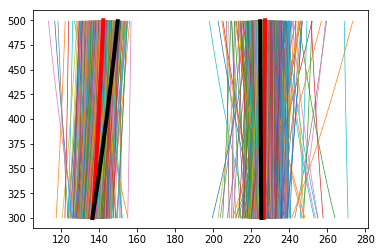

In [51]:
comp1_params=[]
comp2_params=[]
comp1_cov=[]
comp2_cov=[]
sp1_ave=[]
sp2_ave=[]
sp_f=list(range(300, 501, 5))
for fq in sp_f:
    sp1_ave.append(pl_av(frequency=fq,phase=[]))
    sp2_ave.append(pl_av(frequency=fq,phase=[]))
#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=4,color='black', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    
#py.axis([100,275,300,500])

for a in range(9661):
    #Load in a pulse at a time
    print(a,pulse_names[a][-19:-9])
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1
    
    fit_spulse = []
    
    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband

        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
        
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
    
        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)
        
        #Find the peaks at each frequency and add to an array
        if fit!=[] and len(y)!=0:
            pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500)
            fit_spulse.append(pulse_subp)
    
    #Find the movement of pulse across frequency and fit equations to them
    comp1_fit, comp2_fit = find_fits(fit_spulse)

    #For all pulses with a comp1 fit, graph the powerlaw equation
    if comp1_fit!=0 and comp1_fit[1]!=0 and comp1_fit[2][0][0]>0 and comp1_fit[1][0][1]<2 and comp1_fit[1][0][0]<750 and comp1_fit[1][0][0]>50:
        x1,y1=create_pl_fit(300,500,comp1_fit[1][0][0],comp1_fit[1][0][1])
        py.plot(y1,x1, lw=0.7)
        comp1_params.extend(comp1_fit[1][0])
        comp1_cov.append(comp1_fit[1][2])
        for i,fq in enumerate(sp_f):
            sp1_ave[i][1].append(powerlaw(fq,comp1_fit[1][0][0],comp1_fit[1][0][1]))

    #For all pulses with a comp2 fit, graph the powerlaw equation
    if comp2_fit!=0 and comp2_fit[1]!=0 and comp2_fit[1][0][0]>-1 and comp2_fit[1][0][1]<2 and comp2_fit[1][0][0]<750 and comp2_fit[1][0][0]>50:
        x2,y2=create_pl_fit(300,500,comp2_fit[1][0][0],comp2_fit[1][0][1])    
        py.plot(y2,x2, lw=0.7)
        comp2_params.extend(comp2_fit[1][0])
        comp2_cov.append(comp2_fit[1][2])
        for i,fq in enumerate(sp_f):
            sp2_ave[i][1].append(comp2_fit[1][0][0]*fq**comp2_fit[1][0][1])
        print(comp2_fit[1][0][0]*fq**comp2_fit[1][0][1])
            

#Create points which are the average of all the points at a given frequency
sp_p1=[]
sp_p2=[]
#Put into arrays for graphing
for fq in sp1_ave:
    sp_p1.append(average(fq[1]))
for fq in sp2_ave:
    sp_p2.append(average(fq[1]))
    
py.plot(sp_p1,sp_f,lw=4,color='red', zorder=50000)   
py.plot(sp_p2,sp_f,lw=4,color='red', zorder=50000)  

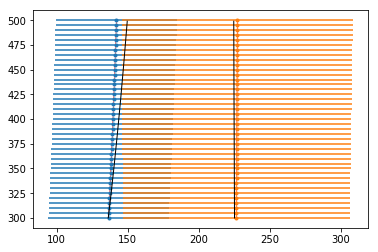

In [54]:
#Create points which are the average of all the points at a given frequency
sp_p1=[]
sp_p2=[]
#Put into arrays for graphing
for fq in sp1_ave:
    sp_p1.append(average(fq[1]))
sp_err1=find_y_err_pl(sp_f, comp1_params, comp1_cov)
for fq in sp2_ave:
    sp_p2.append(average(fq[1]))
sp_err2=find_y_err_pl(sp_f, comp2_params, comp2_cov)
    
py.plot(sp_p1,sp_f,lw=0.5,color='red')   
py.plot(sp_p2,sp_f,lw=0.5,color='red')  
py.errorbar(sp_p1,sp_f,xerr=sp_err1,fmt='.')
py.errorbar(sp_p2,sp_f,xerr=sp_err2,fmt='.')

#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=1,color='black', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=1,color='black', zorder=100000)  

In [59]:
sp1_ave[9]

pl_av(frequency=345, phase=[148.1586173834725, 144.90742449016741, 135.83080692144145, 134.4372345460995, 139.96311358140093, 148.1890375099012, 147.25481669111096, 141.10737065152856, 138.07388996972907, 148.93951559630892, 135.29805943732111, 150.7702161629653, 142.69655360133663, 143.63749981060678, 148.34181122539883, 146.27503332741009, 143.9369834869364, 143.1780315557013, 141.18133456862154, 140.1692710516725, 137.04655617026523, 134.75263465488172, 136.679960018592, 139.37197599095225, 145.7210080983956, 139.4854932725301, 137.69859458017058, 139.32319069866494, 151.30208791044188, 136.06539149180898, 144.35413082590233, 131.8865542956104, 132.03163531103104, 131.10461332883347, 145.4341863878139, 145.4438413647884, 147.34047915690695, 144.24243015945987, 142.49890081398786, 142.4290568437344, 135.00189555087505, 144.16971362933867, 137.12242183680894, 150.79361822839618, 144.4187055268119, 140.9094282849329, 138.4186765696907, 134.73799997016695, 133.24161920907656, 130.692356

In [53]:
sp_params=[[] for i in range(20)]
sp_cov=[[] for i in range(20)]
sp_ave=[[] for i in range(20)]
sp_f=list(range(300, 501, 5))
for i in range(len(sp_ave)):
    for fq in sp_f:
        sp1_ave[i].append(pl_av(frequency=fq,phase=[]))
        sp2_ave[i].append(pl_av(frequency=fq,phase=[]))
#Graph what the average components are doing
ax1,ay1=create_pl_fit(300,500,74.480,0.147)
py.plot((np.array(ay1)-36),ax1,lw=4,color='black', zorder=100000)   
ax2,ay2=create_pl_fit(300,500,267.242,-0.004)
py.plot((np.array(ay2)-36),ax2,lw=4,color='black', zorder=100000)    
#py.axis([100,275,300,500])

for a in range(200,300):
    #Load in a pulse at a time
    print(a,pulse_names[a][-19:-9])
    single_pulse = np.loadtxt(fname=pulse_names[a], dtype=fulldatatype)
    no_freq_bands = max(single_pulse['frequency'])+1
    
    fit_spulse = []
    
    #Look at one frequency at a time
    for b in range(no_freq_bands):
        freqband = b
        f = single_pulse['frequency'] == freqband

        x=single_pulse['phase'][f]
        y=single_pulse['intensity'][f]
        
        noise = sigmaClip(y)
        error = np.nanstd(noise[1])
    
        if len(y)!=0:
            fit, params, sigma, cov, chir=fitting_gaussians(x,y,error)
        
        #Find the peaks at each frequency and add to an array
        if fit!=[] and len(y)!=0:
            pulse_subp = gauss_peaksn(fit, no_freq_bands, freqband, cov, params, 300, 500)
            fit_spulse.append(pulse_subp)
    
    #Find the movement of pulse across frequency and fit equations to them
    comp1_fit, comp2_fit = find_fits(fit_spulse)

    #For all pulses with a comp1 fit, graph the powerlaw equation
    if comp1_fit!=0 and comp1_fit[1]!=0 and comp1_fit[2][0][0]>-1 and comp1_fit[1][0][1]<2 and comp1_fit[1][0][0]<750 and comp1_fit[1][0][0]>50:
        x1,y1=create_pl_fit(300,500,comp1_fit[1][0][0],comp1_fit[1][0][1])
        py.plot(y1,x1, lw=0.7)
        y=powerlaw(300,comp1_fit[1][0][0],comp1_fit[1][0][1])
        
        sp_params.extend(comp1_fit[1][0])
        comp1_cov.append(comp1_fit[1][2])
        for i,fq in enumerate(sp_f):
            sp1_ave[i][1].append(powerlaw(fq,comp1_fit[1][0][0],comp1_fit[1][0][1]))

    #For all pulses with a comp2 fit, graph the powerlaw equation
    if comp2_fit!=0 and comp2_fit[1]!=0 and comp2_fit[1][0][0]>-1 and comp2_fit[1][0][1]<2 and comp2_fit[1][0][0]<750 and comp2_fit[1][0][0]>50:
        x2,y2=create_pl_fit(300,500,comp2_fit[1][0][0],comp2_fit[1][0][1])    
        py.plot(y2,x2, lw=0.7)
        comp2_params.extend(comp2_fit[1][0])
        comp2_cov.append(comp2_fit[1][2])
        for i,fq in enumerate(sp_f):
            sp2_ave[i][1].append(comp2_fit[1][0][0]*fq**comp2_fit[1][0][1])
        print(comp2_fit[1][0][0]*fq**comp2_fit[1][0][1])
            

#Create points which are the average of all the points at a given frequency
sp_p1=[]
sp_p2=[]
#Put into arrays for graphing
for fq in sp1_ave:
    sp_p1.append(average(fq[1]))
for fq in sp2_ave:
    sp_p2.append(average(fq[1]))
    
py.plot(sp_p1,sp_f,lw=4,color='red', zorder=50000)   
py.plot(sp_p2,sp_f,lw=4,color='red', zorder=50000)  

AttributeError: 'pl_av' object has no attribute 'append'